## Assignment 3 NLP


#### Downloading and tokenizing Brown and Gutenberg corpus

In [3]:
import nltk
from nltk.corpus import brown, gutenberg
from gensim.models import TfidfModel, Word2Vec
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
nltk.download('brown')
nltk.download('gutenberg')

[nltk_data] Downloading package brown to /Users/nikil/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package gutenberg to /Users/nikil/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [5]:
brown_sents = brown.sents()
gutenberg_sents = gutenberg.sents()

brown_tokenized = [nltk.word_tokenize(' '.join(sent)) for sent in brown_sents]
gutenberg_tokenized = [nltk.word_tokenize(' '.join(sent)) for sent in gutenberg_sents]

In [6]:
print(len(brown.words()))
print(len(gutenberg.words()))

1161192
2621613


#### Training TF-IDF

In [62]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/nikil/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/nikil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [71]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer

raw_docs = brown.sents(categories=['news'])
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
preprocessed_docs = []
for doc in raw_docs:
    tokens = [token.lower() for token in word_tokenize(' '.join(doc)) if token.lower() not in stop_words and token not in punctuations]
    preprocessed_docs.append(' '.join(tokens))

corpus = ' '.join(preprocessed_docs)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([corpus])

raw_docs_g = gutenberg.sents('melville-moby_dick.txt')
preprocessed_docs_g = []
for doc in raw_docs_g:
    tokens = [token.lower() for token in word_tokenize(' '.join(doc)) if token.lower() not in stop_words and token not in punctuations]
    preprocessed_docs_g.append(' '.join(tokens))

corpus_g = ' '.join(preprocessed_docs_g)

vectorizer_g = TfidfVectorizer()
tfidf_matrix_g = vectorizer_g.fit_transform([corpus_g])



#### Training Word2Vec and finding the best model

In [9]:
import matplotlib.pyplot as plt
context_window_sizes = [1, 2, 5, 10]
vector_sizes = [10, 50, 100, 300]
iteration_num = 100

similarity_scores = {}

for context_window_size in context_window_sizes:
    for vector_size in vector_sizes:
        print(f"Training Word2Vec model with context window size {context_window_size} and vector size {vector_size}")
        brown_w2v = Word2Vec(brown_tokenized, vector_size=vector_size, window=context_window_size, min_count=5, workers=4, epochs=iteration_num)
        gutenberg_w2v = Word2Vec(gutenberg_tokenized, vector_size=vector_size, window=context_window_size, min_count=5, workers=4, epochs=iteration_num)

        # Evaluate the models
        def evaluate_similarity(model, dictionary, corpus, word_pairs):
            sims = []
            for pair in word_pairs:
                try:
                    vec1 = model.wv[dictionary.doc2bow(nltk.word_tokenize(pair[0]))[0][0]]
                    vec2 = model.wv[dictionary.doc2bow(nltk.word_tokenize(pair[1]))[0][0]]
                    sim = cosine_similarity([vec1], [vec2])[0][0]
                    sims.append(sim)
                except:
                    pass
            return sims
        
        #finding the best model with some sample pairs
        word_pairs = [('happy', 'glad'), ('boy', 'girl'), ('king', 'queen'), ('sad', 'cry')]
        brown_w2v_sims = evaluate_similarity(brown_w2v, Dictionary(brown_tokenized), brown_tokenized, word_pairs)
        gutenberg_w2v_sims = evaluate_similarity(gutenberg_w2v, Dictionary(gutenberg_tokenized), gutenberg_tokenized, word_pairs)

        avg_similarity_score = (sum(brown_w2v_sims) + sum(gutenberg_w2v_sims)) / (len(brown_w2v_sims) + len(gutenberg_w2v_sims))
        similarity_scores[(context_window_size, vector_size)] = avg_similarity_score


best_model = max(similarity_scores, key=similarity_scores.get)
print(f"Best Word2Vec model: context window size = {best_model[0]}, vector size = {best_model[1]}, similarity score = {similarity_scores[best_model]}")


Training Word2Vec model with context window size 1 and vector size 10
Training Word2Vec model with context window size 1 and vector size 50
Training Word2Vec model with context window size 1 and vector size 100
Training Word2Vec model with context window size 1 and vector size 300
Training Word2Vec model with context window size 2 and vector size 10
Training Word2Vec model with context window size 2 and vector size 50
Training Word2Vec model with context window size 2 and vector size 100
Training Word2Vec model with context window size 2 and vector size 300
Training Word2Vec model with context window size 5 and vector size 10
Training Word2Vec model with context window size 5 and vector size 50
Training Word2Vec model with context window size 5 and vector size 100
Training Word2Vec model with context window size 5 and vector size 300
Training Word2Vec model with context window size 10 and vector size 10
Training Word2Vec model with context window size 10 and vector size 50
Training Wor

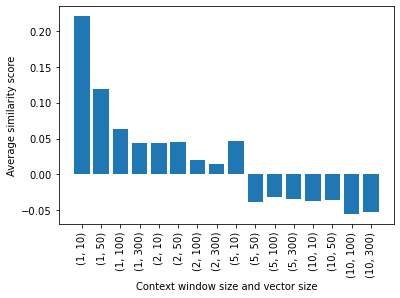

In [10]:
plt.bar(range(len(similarity_scores)), list(similarity_scores.values()), align='center')
plt.xticks(range(len(similarity_scores)), list(similarity_scores.keys()),rotation=90)
plt.xlabel('Context window size and vector size')
plt.ylabel('Average similarity score')
plt.show()

In [11]:
brown_w2v = Word2Vec(brown_tokenized, vector_size=10, window=1, min_count=5, workers=4, epochs=iteration_num)
gutenberg_w2v = Word2Vec(gutenberg_tokenized, vector_size=10, window=1, min_count=5, workers=4, epochs=iteration_num)

#### Finding top 10 similar words for Simlex-999

In [18]:
top_10_G = {}

with open('/Users/nikil/Downloads/SimLex-999/SimLex-999.txt') as file:
    next(file) 
    for row in file:
        cols = row.strip().split('\t')
        word1, word2, score = cols[0], cols[1], cols[3]
        if word1 not in top_10_G:
            top_10_G[word1] = []
        top_10_G[word1].append((word2, float(score)))
        if word2 not in top_10_G:
            top_10_G[word2] = []
        top_10_G[word2].append((word1, float(score)))

for word in top_10_G:
    top_10_G[word] = sorted(top_10_G[word], key=lambda x: x[1], reverse=True)

for word in top_10_G:
    top_10_G[word] = top_10_G[word][:10]



#### Finding top 10 similar words for w in G using baseline Word2Vec

In [74]:
import numpy as np

top_10_v1c1 = {}
model = brown_w2v
for word in top_10_G:
    if word in model.wv.key_to_index:
        word_vector = model.wv.get_vector(word)
        similarities = model.wv.most_similar(word_vector, topn=10)
        top_10_v1c1[word] = similarities
        
top_10_v1c2 = {}
model = gutenberg_w2v
for word in top_10_G:
    if word in model.wv.key_to_index:
        word_vector = model.wv.get_vector(word)
        similarities = model.wv.most_similar(word_vector, topn=10)
        top_10_v1c2[word] = similarities


In [75]:
print(top_10_v1c2)

{'old': [('old', 0.9999999403953552), ('athletic', 0.9729483723640442), ('English', 0.9593620300292969), ('buzz', 0.9520273804664612), ('elderly', 0.9511699676513672), ('hits', 0.9480834007263184), ('aged', 0.9388458132743835), ('unfolding', 0.9354093670845032), ('tempered', 0.9182633757591248), ('vindictive', 0.9154890775680542)], 'new': [('new', 1.0), ('final', 0.967767596244812), ('electric', 0.9648320078849792), ('fatal', 0.964688241481781), ('measureless', 0.9605309367179871), ('outward', 0.9563416242599487), ('obscure', 0.9538259506225586), ('original', 0.9526119232177734), ('tender', 0.9500624537467957), ('hapless', 0.944083034992218)], 'smart': [('smart', 0.9999998807907104), ('handsome', 0.9767388701438904), ('elegant', 0.9547520279884338), ('comic', 0.945650041103363), ('quicker', 0.9386002421379089), ('_very_', 0.9369739890098572), ('solitude', 0.9367491006851196), ('commonplace', 0.9367083311080933), ('promptitude', 0.9337115287780762), ('liberally', 0.9334036707878113)], '

#### Finding top 10 similar words for w in G using baseline TF-IDF

In [68]:
top_10_v2c1 = {}
feature_names = vectorizer.get_feature_names()
for word in top_10_G:
    if word in vectorizer.vocabulary_:
        word_index = vectorizer.vocabulary_[word]
        word_tfidf_scores = [(feature_names[i], tfidf_matrix[0, i]) for i in tfidf_matrix[0, :].indices]
        word_tfidf_scores_sorted = sorted(word_tfidf_scores, key=lambda x: x[1], reverse=True)
        top_10_v2c1[word] = word_tfidf_scores_sorted[:11]
        
print(top_10_v2c1)


{'old': [('said', 0.31957915136553844), ('mrs', 0.20150803632900946), ('would', 0.19599805096063813), ('new', 0.19048806559226678), ('one', 0.17710667255479348), ('year', 0.16923526488569154), ('two', 0.15034388647984692), ('last', 0.1408981972769246), ('mr', 0.13381393037473285), ('president', 0.1283039450063615), ('first', 0.1283039450063615)], 'new': [('said', 0.31957915136553844), ('mrs', 0.20150803632900946), ('would', 0.19599805096063813), ('new', 0.19048806559226678), ('one', 0.17710667255479348), ('year', 0.16923526488569154), ('two', 0.15034388647984692), ('last', 0.1408981972769246), ('mr', 0.13381393037473285), ('president', 0.1283039450063615), ('first', 0.1283039450063615)], 'intelligent': [('said', 0.31957915136553844), ('mrs', 0.20150803632900946), ('would', 0.19599805096063813), ('new', 0.19048806559226678), ('one', 0.17710667255479348), ('year', 0.16923526488569154), ('two', 0.15034388647984692), ('last', 0.1408981972769246), ('mr', 0.13381393037473285), ('president', 

In [72]:
top_10_v2c2 = {}
feature_names_g = vectorizer_g.get_feature_names()
for word in top_10_G:
    if word in vectorizer_g.vocabulary_:
        word_index = vectorizer_g.vocabulary_[word]
        word_tfidf_scores = [(feature_names_g[i], tfidf_matrix_g[0, i]) for i in tfidf_matrix_g[0, :].indices]
        word_tfidf_scores_sorted = sorted(word_tfidf_scores, key=lambda x: x[1], reverse=True)
        top_10_v2c2[word] = word_tfidf_scores_sorted[:11]
        
print(top_10_v2c2)



{'old': [('whale', 0.3650550398044452), ('one', 0.2742379214191632), ('like', 0.19265139539435241), ('upon', 0.1685327508395726), ('man', 0.15692007012801193), ('ship', 0.1542402207330364), ('ahab', 0.15215589342583322), ('ye', 0.14054321271427256), ('sea', 0.13548127496820764), ('old', 0.1339924697487768), ('would', 0.12863277095882572)], 'new': [('whale', 0.3650550398044452), ('one', 0.2742379214191632), ('like', 0.19265139539435241), ('upon', 0.1685327508395726), ('man', 0.15692007012801193), ('ship', 0.1542402207330364), ('ahab', 0.15215589342583322), ('ye', 0.14054321271427256), ('sea', 0.13548127496820764), ('old', 0.1339924697487768), ('would', 0.12863277095882572)], 'smart': [('whale', 0.3650550398044452), ('one', 0.2742379214191632), ('like', 0.19265139539435241), ('upon', 0.1685327508395726), ('man', 0.15692007012801193), ('ship', 0.1542402207330364), ('ahab', 0.15215589342583322), ('ye', 0.14054321271427256), ('sea', 0.13548127496820764), ('old', 0.1339924697487768), ('would

#### Evaluation

In [52]:
pip install pytrec_eval --upgrade

Note: you may need to restart the kernel to use updated packages.


In [76]:
import pytrec_eval

relevance_judgments = {
    k: {w[0]: int(float(w[1])) for w in v}
    for k, v in top_10_G.items()
}
supported_measures = {measure_name: pytrec_eval.supported_measures for measure_name in pytrec_eval.supported_measures}

evaluator = pytrec_eval.RelevanceEvaluator(
    relevance_judgments,
    supported_measures["ndcg"]
)

results = evaluator.evaluate(
    {k: {w[0]: w[1] for w in v} for k, v in top_10_v1c1.items()}
)
avg_ndcg = sum(result["ndcg"] for result in results.values()) / len(results)
print("Average nDCG for brown corpus Word2Vec:", avg_ndcg)

results = evaluator.evaluate(
    {k: {w[0]: w[1] for w in v} for k, v in top_10_v1c2.items()}
)
avg_ndcg = sum(result["ndcg"] for result in results.values()) / len(results)
print("Average nDCG for gutenberg corpus Word2Vec:", avg_ndcg)

results = evaluator.evaluate(
    {k: {w[0]: w[1] for w in v} for k, v in top_10_v2c1.items()}
)
avg_ndcg = sum(result["ndcg"] for result in results.values()) / len(results)
print("Average nDCG for brown corpus TF-IDF:", avg_ndcg)

results = evaluator.evaluate(
    {k: {w[0]: w[1] for w in v} for k, v in top_10_v2c2.items()}
)
avg_ndcg = sum(result["ndcg"] for result in results.values()) / len(results)
print("Average nDCG for gutenberg corpus TF-IDF:", avg_ndcg)



Average nDCG for brown corpus Word2Vec: 0.012763586163182692
Average nDCG for gutenberg corpus Word2Vec: 0.01625803417547127
Average nDCG for brown corpus TF-IDF: 0.0020938985978506
Average nDCG for gutenberg corpus TF-IDF: 0.0031861771348379395


#### Bar plot of Result

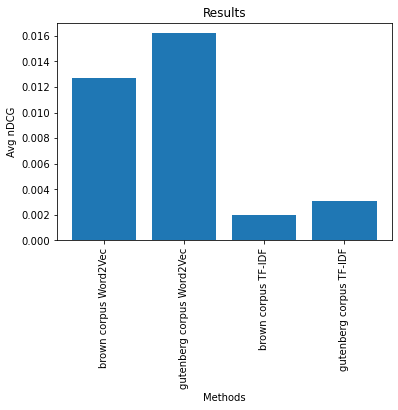

In [81]:
ncdg = [0.0127, 0.0162, 0.0020, 0.0031]
labels = ['brown corpus Word2Vec', 'gutenberg corpus Word2Vec', 'brown corpus TF-IDF', 'gutenberg corpus TF-IDF']
plt.bar(labels, ncdg)
plt.xlabel('Methods')
plt.xticks(rotation=90)
plt.ylabel('Avg nDCG')
plt.title('Results')
plt.show()
